# Direct S3 Access GEDI L4A from the NASA EarthData Cloud

GEDI L4A Datasets are available through NASA's EarthData Cloud. NASA EarthData on Cloud is always free and accessible via either HTTPS or direct [S3](https://aws.amazon.com/s3/) bucket access. With direct S3 access, you can bring your "code to the data", making your processing faster and scalable. Direct S3 access to NASA Earthdata on Cloud is only available if your Amazon Web Services ([AWS](https://aws.amazon.com/)) instance is set up in the `us-west-2` region. If you are new to the EarthData Cloud, these NASA EarthData [primers](https://www.earthdata.nasa.gov/learn/webinars-and-tutorials/cloud-primer-amazon-web-services) and [tutorials](https://www.earthdata.nasa.gov/learn/webinars-and-tutorials/how-cloud-earth-scientists) are good resources to get you started. 

To access a Juypter Notebook on [AWS EC2](https://aws.amazon.com/ec2/) instance:
1. On the AWS EC2 instance, start Juypter Notebook on port 8888 with the 'no-browser' parameter: `jupyter notebook --no-browser --port=8888`
1. On your local machine, forward port 8000 to the remote port 8888 : `ssh -i my-key-pair.pem -L 8000:localhost:8888 my-instance-user-name@my-instance-IPv6-address`
1. Now, the Jupyter Notebook can be accessed at `http://localhost:8000` in your local browser.

**Important**: [NASA EarthData Login (EDL)](https://urs.earthdata.nasa.gov/) is required to obtain the S3 temporary credentials and direct access S3 objects bucket. First, set up NASA Earthdata Login authentication using a `.netrc` file. Please refer to the instructions here: https://wiki.earthdata.nasa.gov/display/EL/How+To+Access+Data+With+cURL+And+Wget.

In this tutorial, we will retrieve GEDI L4A dataset from the EarthData Cloud using direct S3 access.

In [1]:
# import python modules
import requests
import s3fs
import h5py
import geopandas as gpd
import contextily as ctx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.ops import orient
from IPython import display
from shapely.geometry import MultiPolygon, Polygon
from datetime import datetime
from multiprocessing import Pool
from posixpath import splitext
from os import path
import warnings
warnings.filterwarnings('ignore')

We will read an area within the [Harvard Forests](https://harvardforest.fas.harvard.edu/) as a GeoJSON file. The Harvard Forests is one of the most extensively studied ecological sites in the United States.

If an area of interest is already defined as a polygon, the polygon file (geojson, shapefile, or kml) can be used to find overlapping GEDI L4A files. More details about this capability are described on [this page](https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html#c-shapefile).

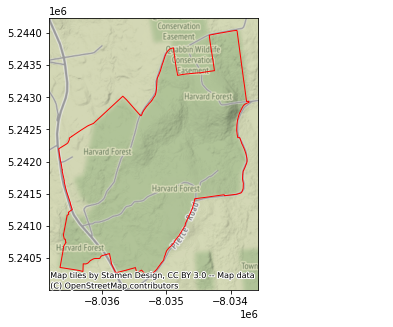

In [2]:
# read geojson
harvard = gpd.read_file("polygons/harvard.json") 
# orient
harvard.geometry = harvard.geometry.apply(orient, args=(1,))

ax=harvard.to_crs(epsg=3857).plot(figsize=(5, 5), edgecolor='red', facecolor='none')
ctx.add_basemap(ax, zoom = 14)

Let's define a function that searches NASA's Common Metadata Repository ([CMR](https://cmr.earthdata.nasa.gov/search)) API to search and find the granules.

In [3]:
def search_cmr(doi: str, geojson):
    # CMR API base url
    cmrurl='https://cmr.earthdata.nasa.gov/search/' 
    # doi search to get concept_id
    doisearch = f'{cmrurl}collections.json?doi={doi}'
    concept_id = requests.get(doisearch).json()['feed']['entry'][0]['id']

    page_num = 1
    page_size = 2000 # CMR page size limit
    s3_arr = []

    while True:
         # defining parameters
        cmr_param = {
            "collection_concept_id": concept_id, 
            "page_size": page_size,
            "page_num": page_num,
            "simplify-shapefile": 'true' # this is needed to bypass 5000 coordinates limit of CMR
        }

        granulesearch = f'{cmrurl}granules.json'
        r = requests.post(granulesearch, data=cmr_param, files=geojson)
        r.raise_for_status()
        granules = r.json()['feed']['entry']
        if granules:
            for g in granules:
                # Get s3 links
                for links in g['links']:
                    if links['href'].startswith('s3://'):
                        s3_arr.append(links['href'])

            page_num += 1
        else: 
            break
            
    return s3_arr 

The above python function `search_cmr` takes two parameters - dataset DOI and geojson object. We can use the above function to query spatially overlapping GEDI L4A granules. 

In [4]:
doi = '10.3334/ORNLDAAC/2056'# GEDI L4A DOI 
geojson = {"shapefile": ("harvard.geojson", harvard.geometry.to_json(), "application/geo+json")}

granule_arr = search_cmr(doi, geojson)

The `granule_arr` contains a list of `s3` granule links, starting with `s3://`. We can print the first two items of the `granule_arr`.

In [5]:
granule_arr = sorted(granule_arr)
granule_arr[:2]

['s3://ornl-cumulus-prod-protected/gedi/GEDI_L4A_AGB_Density_V2_1/data/GEDI04_A_2019229131935_O03846_02_T03642_02_002_02_V002.h5',
 's3://ornl-cumulus-prod-protected/gedi/GEDI_L4A_AGB_Density_V2_1/data/GEDI04_A_2019246121050_O04109_03_T04380_02_002_02_V002.h5']

Let's plot the monthly number of granules overlapping the above area within the Harvard Forest.

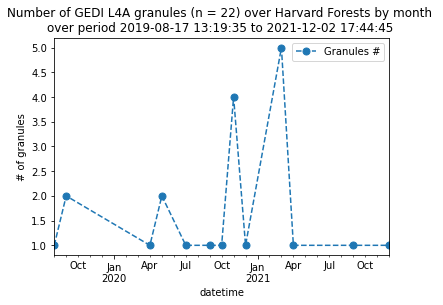

In [6]:
fmt = '%Y%j%H%M%S' # GEDI granule name has date time as YYYYDDDHHMMSS
granule_dt = [g.split('/')[-1].split('_')[2] for g in granule_arr]
df = pd.DataFrame(list(zip(granule_dt, granule_arr)), columns =['datetime', 'Granules #'])

df['datetime'] = pd.to_datetime(df['datetime'], format=fmt)
df.set_index('datetime', inplace=True)

# plotting a monthly granule count plot
title = f'''Number of GEDI L4A granules (n = {len(granule_arr)}) over Harvard Forests by month 
over period {df.index.min()} to {df.index.max()} '''
ax = df.groupby(df.index.to_period('M')).agg('count').plot(style='o--', markersize=7, title=title)
ax.set_ylabel("# of granules")
plt.show()

A temporary S3 Credentials is needed for read-only, same-region, direct access to S3 objects on the Earthdata cloud. Each of the DAACs has its own endpoint. More information about S3 credentials for ORNL DAAC is available at: https://data.ornldaac.earthdata.nasa.gov/s3credentialsREADME. 

We will now retrieve the credentials for ORNL DAAC for GEDI L4A access. These credentials are temporary and currently valid for one hour.

In [7]:
# python function to get s3 credentials
def get_s3credentials(daac: str):
    # DAAC S3 Credentials Endpoint
    earthadata_s3 = f"https://data.{daac}.earthdata.nasa.gov/s3credentials"
    r = requests.get(earthadata_s3)
    r.raise_for_status()
    return r.json()

# get s3 credentials
s3credentials = get_s3credentials("ornldaac")
# print expiration datetime
print(f'The S3 credentials will expire on {s3credentials["expiration"]} UTC')

The S3 credentials will expire on 2022-06-14 20:28:08+00:00 UTC


We will use [S3Fs](https://s3fs.readthedocs.io/),  Pythonic file interface to S3 for file-system style access. Alternatively, you can use [Boto3](https://aws.amazon.com/sdk-for-python/), AWS Software Development Kit (SDK) for Python. We will pass S3 credentials to S3Fs class `S3FileSystem`.

In [8]:
fs_s3 = s3fs.S3FileSystem(anon=False, 
                          key=s3credentials['accessKeyId'], 
                          secret=s3credentials['secretAccessKey'], 
                          token=s3credentials['sessionToken'])

For this tutorial, we will be retrieving the AGBD variables `agbd` and `l4_quality_flag`, in addition to the variables that provide geolocation (`lat_lowestmode`, `lon_lowestmode`, `elev_lowestmode`) and shot identifier (`shot_number`), and save them as `csv` files.

In [11]:
# setting header variables
headers = ['lat_lowestmode', 'lon_lowestmode', 'elev_lowestmode', 'shot_number']
variables = ['agbd', 'l4_quality_flag']
headers.extend(variables)
# outfiles
outfiles = []
for s3_url in granule_arr:
    with fs_s3.open(s3_url, mode='rb') as fh:
        with h5py.File(fh) as hf:
            print(f"Downloading {s3_url}")
            out_csv = splitext(path.basename(s3_url))[0] + '.csv'
            outfiles.append(out_csv)
            with open(out_csv, "w") as f:
                f.write(','.join(headers)+'\n')
            for var in list(hf.keys()):
                if var.startswith('BEAM'):
                    lat = hf[var]['lat_lowestmode']
                    lon = hf[var]['lon_lowestmode']
                    df = pd.DataFrame({'lat_lowestmode': lat, 'lon_lowestmode': lon})
                    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon_lowestmode, df.lat_lowestmode)) 
                    gdf_harvd = gdf[gdf['geometry'].within(harvard.geometry[0])]   
                    if not gdf_harvd.empty:
                        for v in headers[2:]:
                            gdf_harvd[v] = None
                        # 3. retrieving variables of interest, agbd, l4_quality_flag in this case.
                        # We are only retriving the shots within subset area.
                        for _, df_gr in gdf_harvd.groupby((gdf_harvd.index.to_series().diff() > 1).cumsum()):
                            i = df_gr.index.min()
                            j = df_gr.index.max()
                            for v in headers[2:]:
                                gdf_harvd.loc[i:j, (v)] = hf[var][v][i:j+1]

                        # saving the output file
                        gdf_harvd[gdf_harvd['agbd'] != -9999].to_csv(out_csv, mode='a', index=False, 
                                                                     header=False, columns=headers)

We will now read the `csv` files into a pandas dataframe and plot the AGBD (mg/ha-1) values of the footprints on a map.

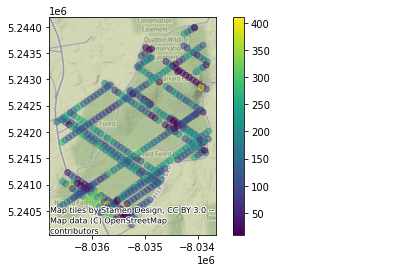

In [12]:
l4a_df = pd.concat(pd.read_csv(f,header=0) for f in outfiles)
l4a_gdf = gpd.GeoDataFrame(l4a_df, geometry=gpd.points_from_xy(l4a_df.lon_lowestmode, l4a_df.lat_lowestmode)) 
l4a_gdf['agbd'] = l4a_gdf['agbd'].astype(float)
l4a_gdf.crs="EPSG:4326"
ax4=l4a_gdf.to_crs(epsg=3857).plot( column='agbd', alpha=0.5,legend=True)
ctx.add_basemap(ax4, zoom=14)